In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install datasets evaluate --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 17.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2024.12.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platf

In [ ]:
import transformers
print(transformers.__version__)


4.51.3


In [ ]:
import torch
from torch.utils.data import DataLoader
from datasets import load_from_disk, DatasetDict
from transformers import AutoImageProcessor, AutoModelForImageClassification, TrainingArguments, Trainer
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize, InterpolationMode
import evaluate

In [ ]:
# Optional: check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [ ]:
save_path = '/content/drive/MyDrive/Multi_Modal/Project/input_full'

from datasets import load_from_disk
# Load the dataset from the saved path
ds = load_from_disk(save_path)['train']  # returns just a Dataset

print(ds)

Dataset({
    features: ['title', 'artist', 'date', 'genre', 'style', 'description', 'filename', 'image', 'embeddings_pca512'],
    num_rows: 84013
})


In [ ]:
ds = ds.class_encode_column("style")

In [ ]:
# Step 3: Split the dataset
ds = ds.shuffle(seed=42)
ds = ds.train_test_split(test_size=0.3, seed=76)
val_test_split = ds["test"].train_test_split(test_size=0.5, seed=67)

final_ds = DatasetDict({
    "train": ds["train"],
    "validation": val_test_split["train"],
    "test": val_test_split["test"]
})

In [ ]:
final_ds['train'].shape

(58809, 9)

## ResNet 50

In [ ]:
import torch
from datasets import load_from_disk, DatasetDict
from transformers import AutoImageProcessor, AutoModelForImageClassification, TrainingArguments, Trainer
import evaluate
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Load processor
processor = AutoImageProcessor.from_pretrained("microsoft/resnet-50")

# Define transform
def transform(example):
    example["pixel_values"] = processor(example["image"], return_tensors="pt")["pixel_values"].squeeze(0)
    return example

final_ds = final_ds.with_transform(transform)

def collate_fn(batch):
    pixel_values = torch.stack([x["pixel_values"] for x in batch])
    labels = torch.tensor([x["style"] for x in batch])
    return {"pixel_values": pixel_values, "labels": labels}

# Prepare label mappings
style_names = final_ds['train'].features['style'].names
id2label = {i: name for i, name in enumerate(style_names)}
label2id = {name: i for i, name in enumerate(style_names)}




/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/266 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [ ]:
# Load ResNet-50 model
model = AutoModelForImageClassification.from_pretrained(
    "microsoft/resnet-50",
    num_labels=len(style_names),
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True
)

# TrainingArguments
training_args = TrainingArguments(
    output_dir="./resnet-wikiart",
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    do_eval=True,
    logging_steps=20,
    logging_dir="./logs_resnet",
    report_to="tensorboard",
    num_train_epochs=3,
    save_total_limit=1,
    remove_unused_columns=False,
)

# Define compute_metrics
accuracy = evaluate.load("accuracy")

def compute_metrics(p):
    preds = p.predictions.argmax(-1)
    return accuracy.compute(predictions=preds, references=p.label_ids)

Some weights of ResNetForImageClassification were not initialized from the model checkpoint at microsoft/resnet-50 and are newly initialized because the shapes did not match:
- classifier.1.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([24]) in the model instantiated
- classifier.1.weight: found shape torch.Size([1000, 2048]) in the checkpoint and torch.Size([24, 2048]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Setup Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=final_ds["train"],
    eval_dataset=final_ds["validation"],
    tokenizer=processor,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
)

# Train
trainer.train()

<ipython-input-17-fe86973d7945>:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
20,3.145000
40,3.071400
60,3.019000
80,2.967300
100,2.912000
120,2.883000
140,2.845600
160,2.823100
180,2.787300
200,2.737100


TrainOutput(global_step=5514, training_loss=2.0298638580759496, metrics={'train_runtime': 2291.5872, 'train_samples_per_second': 76.989, 'train_steps_per_second': 2.406, 'total_flos': 3.753681394267865e+18, 'train_loss': 2.0298638580759496, 'epoch': 3.0})

In [ ]:
# Final test evaluation
test_results = trainer.evaluate(final_ds["test"])
print("✅ Test Accuracy:", test_results["eval_accuracy"])

✅ Test Accuracy: 0.4257260752261546


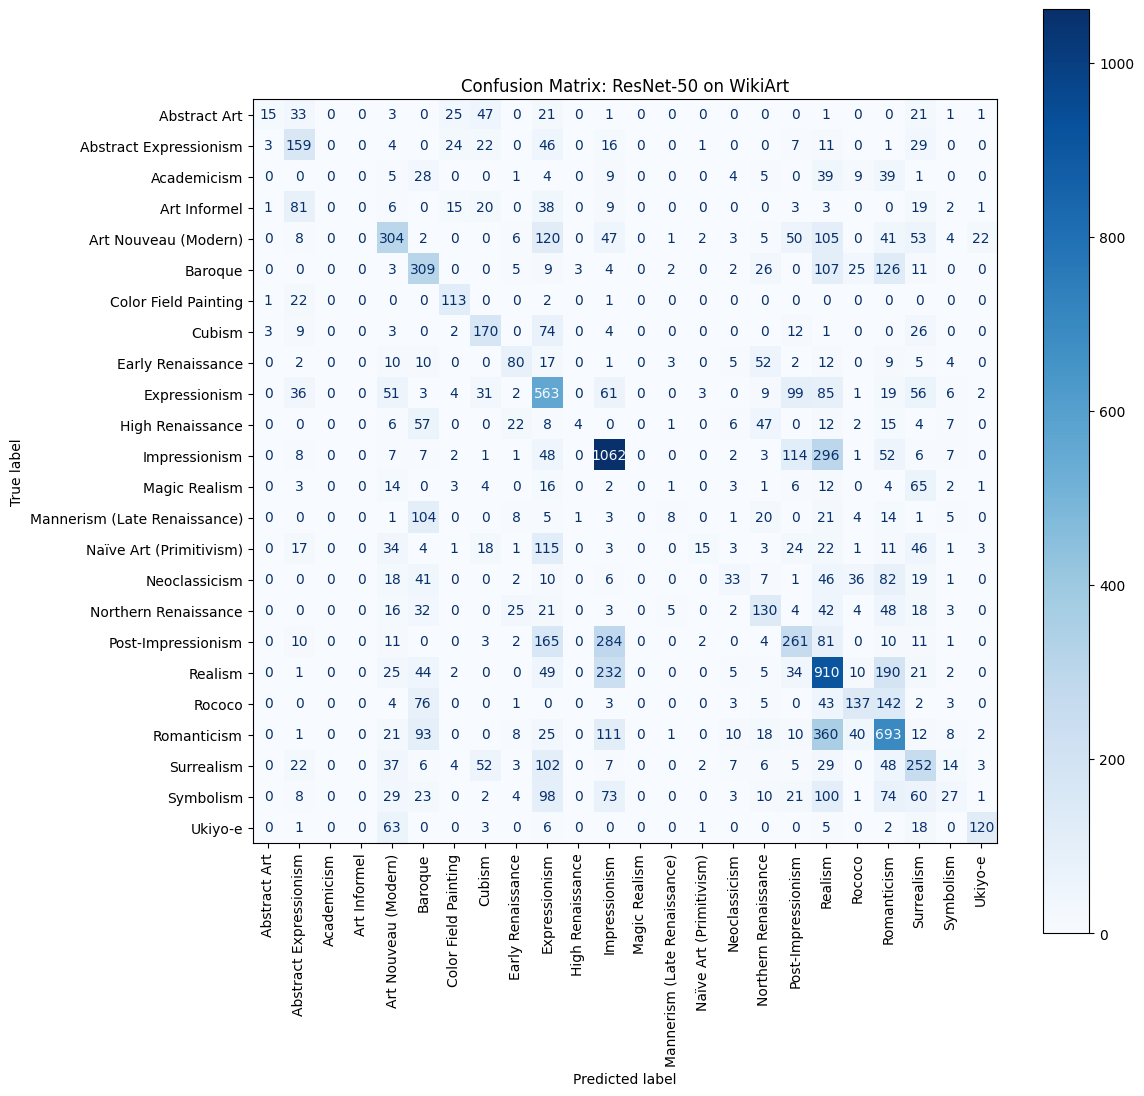

In [ ]:
# Confusion matrix
predictions = trainer.predict(final_ds["test"])
y_true = predictions.label_ids
y_pred = predictions.predictions.argmax(axis=-1)

labels = [final_ds["test"].features["style"].int2str(i) for i in range(len(style_names))]
cm = confusion_matrix(y_true, y_pred)

fig, ax = plt.subplots(figsize=(12, 12))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(xticks_rotation=90, ax=ax, cmap='Blues')
plt.title("Confusion Matrix: ResNet-50 on WikiArt")
plt.show()

## Find two images in test dataset

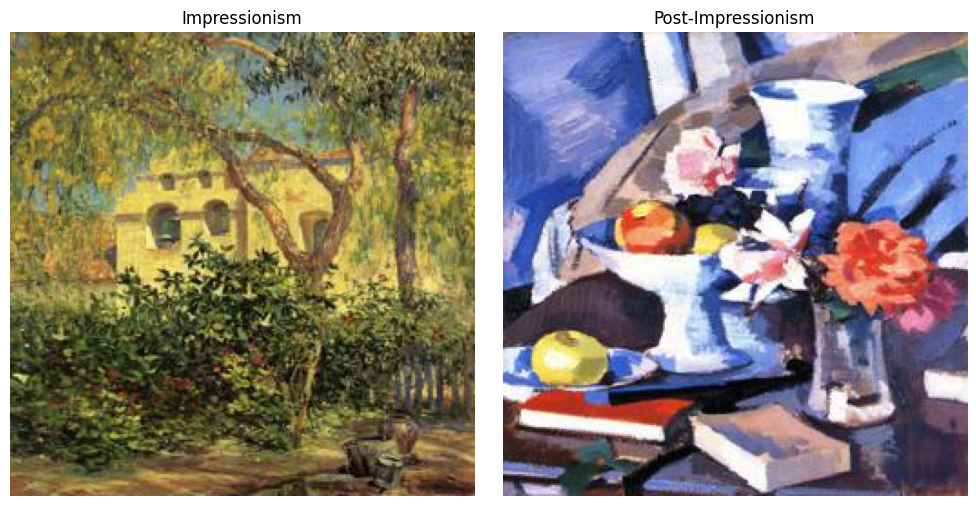

In [ ]:
import matplotlib.pyplot as plt

# Step 1: Find indices where style matches
# Convert all styles in the test set
all_styles = [final_ds["test"].features["style"].int2str(label) for label in final_ds["test"]["style"]]

# Get indices
impressionism_idx = next(i for i, style in enumerate(all_styles) if style == "Impressionism")
post_impressionism_idx = next(i for i, style in enumerate(all_styles) if style == "Post-Impressionism")

# Step 2: Fetch examples
impressionism_example = final_ds["test"][impressionism_idx]
post_impressionism_example = final_ds["test"][post_impressionism_idx]

# Step 3: Plot them
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(impressionism_example["image"])
axes[0].set_title("Impressionism")
axes[0].axis("off")

axes[1].imshow(post_impressionism_example["image"])
axes[1].set_title("Post-Impressionism")
axes[1].axis("off")

plt.tight_layout()
plt.show()


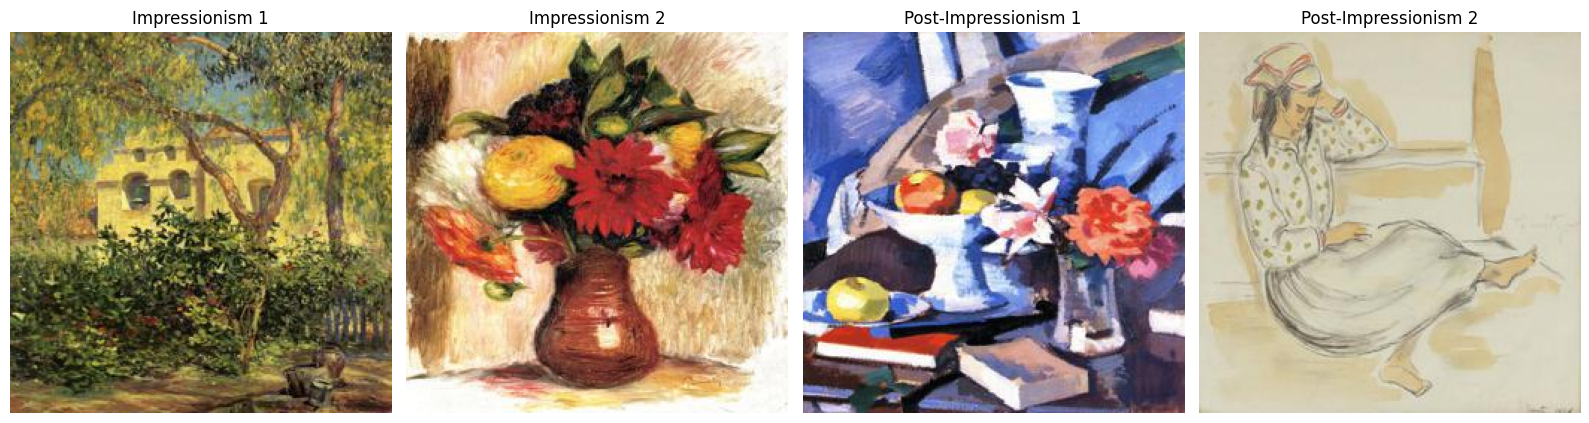

In [ ]:
import matplotlib.pyplot as plt

# Step 1: Find indices where style matches
all_styles = [final_ds["test"].features["style"].int2str(label) for label in final_ds["test"]["style"]]

# Get two indices for each style
impressionism_indices = [i for i, style in enumerate(all_styles) if style == "Impressionism"][:2]
post_impressionism_indices = [i for i, style in enumerate(all_styles) if style == "Post-Impressionism"][:2]

# Fetch examples
examples = [final_ds["test"][idx] for idx in (impressionism_indices + post_impressionism_indices)]
titles = ["Impressionism 1", "Impressionism 2", "Post-Impressionism 1", "Post-Impressionism 2"]

# Step 2: Plot them
fig, axes = plt.subplots(1, 4, figsize=(16, 5))  # 1 row, 4 columns

for ax, example, title in zip(axes, examples, titles):
    ax.imshow(example["image"])
    ax.set_title(title)
    ax.axis("off")

plt.tight_layout()
plt.show()
